# Correlations between the EPSC and IPSCs with increasing input

Since the CA1 neuron saturates in its $V_{max}$ with increasing input, and this saturation is dependent on the inhibition, the shapes of the two functions must approach each other with increases in input.

$$C(t) = E(t) - I(t)$$
As $C_{max}$ goes to constant, E and I should converge.

In [1]:
import numpy as np
import pickle
#%matplotlib notebook
from Linearity import Neuron
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import sys
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
fileList = ['/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c1_EI/plots/c1_EI_fits.pkl', '/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c2_EI/plots/c2_EI_fits.pkl', '/media/sahil/NCBS_Shares_BGStim/patch_data/170117/c1_EI/plots/c1_EI_fits.pkl', '/media/sahil/NCBS_Shares_BGStim/patch_data/170117/c2_EI/plots/c2_EI_fits.pkl', '/media/sahil/NCBS_Shares_BGStim/patch_data/170317/c5_EI/plots/c5_EI_fits.pkl']

In [3]:
fileList = ['/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c5_EI/plots/c5_EI.pkl']

### Sliding window cross correlation between E and I

In [4]:
def periodicallyNormalizedCrossCorrelation(vec1, vec2, windowSize):
    ''' Returns the cross correlation of 2 vectors by running a window of same size through the 2 vectors'''
    normalizationLength = windowSize - 1
    assert len(vec1) == len(vec2), "Lengths of vectors don't match"
    return np.array([np.correlate(normalizeTrace(vec1[i:i+windowSize])/normalizationLength, normalizeTrace(vec2[i:i+windowSize]))[0] for i in range(0,len(vec1),windowSize)])

In [5]:
def traceNormalizedCrossCorrelation(vec1, vec2, windowSize):
    ''' Returns the cross correlation of 2 vectors by running a window of same size through the 2 vectors'''
    assert len(vec1) == len(vec2), "Lengths of vectors don't match"
    crossCorr = np.correlate(vec1, vec2,mode='full')
    return crossCorr
    #return np.array([np.correlate(vec1[i:i+windowSize], vec2[i:i+windowSize],mode='full')[0] for i in range(0,len(vec1),windowSize)])

### Sorted trials with maximum excitatory current values.

In [6]:
def sortTrialsByGmax(trials):
#     gmax_array = np.array([trial.fit["g_max"].value for trial in trials])
    gmax_array = np.array([trial.feature[0] for trial in trials])
    sortIndices = np.argsort(gmax_array)
    return sortIndices, gmax_array[sortIndices]

### Normalize to $\frac{x-\mu}{\sigma}$ for normalized correlation coefficients

In [7]:
def normalizeTrace(trace):
    return (trace - np.mean(trace))/(np.std(trace))

### Plot heatmap with the same.

In [8]:
def heatmap(corrMatrix, extent, title, fig = None, ax = None):
    if not ax:
        fig, ax = plt.subplots()
    
    heatmap = ax.imshow(corrMatrix, cmap='plasma', aspect='auto', extent=extent, origin='lower',vmin=-1, vmax=1)
    cbar = fig.colorbar(heatmap, orientation='horizontal')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current (pA)")
    cbar.ax.get_xaxis().labelpad = 15
    cbar.ax.set_xlabel('Normalized correlation')
    if not ax:
        return fig

In [9]:
def phaseplot(x,y,axis,c='blue'):
    phasePlot = axis.plot(x,y,c=c)
    return phasePlot

In [10]:
def colorline(
        x, y, z=None, cmap='inferno', norm=plt.Normalize(0.0, 1.0),
        linewidth=0.5, alpha=0.5):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

### Plotting EI correlations over time for four different cells with current recordings.

/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c5_EI/plots/c5_EI.pkl
<Linearity.Neuron instance at 0x7fda6fe28758>
Trace normalized correlations


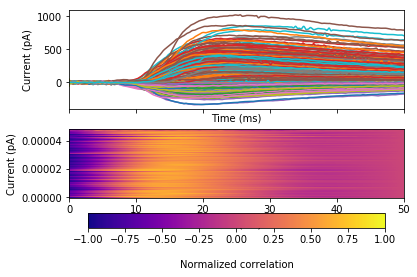

Trace averaged and normalized correlations


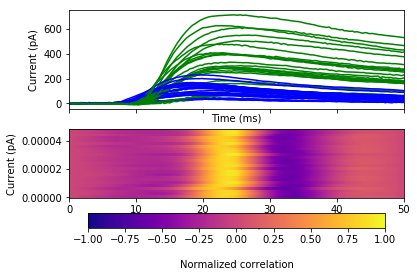

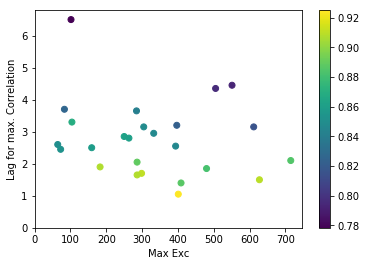

In [11]:
for i,analysisFile in enumerate(fileList):
    plotDir = os.path.dirname(analysisFile)
    print (analysisFile)
    neuron = Neuron.load(analysisFile)
    print(neuron)

    #with open (analysisFile,'rb') as p:
    #    neuron = pickle.load(p)

    windowSize = 20
    fullWindowSize = 1000
    totalTime = fullWindowSize/windowSize #ms
    
    excTrialList, inhTrialList= [], []
    exc, inh = neuron.experiment[1], neuron.experiment[2]
    for numSquares in (set(exc) & set(inh)):
        excTrialList+=[exc[numSquares].trial[trialNum] for trialNum in exc[numSquares].trial]
        inhTrialList+=[inh[numSquares].trial[trialNum] for trialNum in inh[numSquares].trial]
    sortIndices, sortedValues = sortTrialsByGmax(excTrialList)
    extent = [0, fullWindowSize/windowSize, min(sortedValues)*1e3, max(sortedValues)*1e3] # tmin, tmax, gmin, gmax in ms, and nA
    
    nrows, ncols = 15,12
    scalingFactor = 1e9 #Converting currents to picoAmperes
    cmap = cm.get_cmap('inferno')
    norm = colors.Normalize(vmin=sortedValues[0]*1e3, vmax=sortedValues[-1]*1e3)
    colorSpace = np.linspace(0.,1.,nrows*ncols)
    
    # Phase plot of E and I
#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(12,8))
#     position = [(x,y) for x in range(nrows) for y in range(ncols)]
#     for trialIndex,pos in zip(sortIndices, position):
#         axis = phaseplot(excTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor, inhTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor, ax[pos[0]][pos[1]], c=cmap(i))
#     fig.text(0.5, 0.0, 'Excitation', ha='center')
#     fig.text(0.0, 0.5, 'Inhibition', va='center', rotation='vertical')
#     fig.tight_layout()
#     fig.show()
    
    # Phase plot of E and I
#     fig, ax = plt.subplots(ncols=2, gridspec_kw = {'width_ratios':[20, 1]})
#     for trialIndex,i in zip(sortIndices[::-1],colorSpace[::-1]):
#         ax[0].plot(excTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor, inhTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor, c=cmap(i), alpha=0.5)
#     ax[0].set_xlabel("Excitation")
#     ax[0].set_ylabel("Inhibition")
#     cbar = matplotlib.colorbar.ColorbarBase(ax[1], cmap=cmap, norm=norm, orientation='vertical')
#     cbar.set_label('$Exc_{max}$')
#     fig.show()
    
#     # Phase plot of E and I colored in time
#     fig, ax = plt.subplots()
#     z = np.linspace(0, 1, len(excTrialList[0].interestWindow[:fullWindowSize]))
#     #plt.sca(ax[0])
#     for trialIndex,i in zip(sortIndices[::-1],colorSpace[::-1]):
#         lc = colorline(excTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor, inhTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor, z)
    
#     ax.set_xlabel("Excitation")
#     ax.set_ylabel("Inhibition")
#     #lc = colorline(x, y, cmap='inferno')
#     cbar = fig.colorbar(lc, norm = colors.Normalize(vmin=0, vmax=len(excTrialList[0].interestWindow[:fullWindowSize])/20))
#     #plt.show()
    
#     #cbar = matplotlib.colorbar.ColorbarBase(ax[1], cmap=cmap, norm=norm, orientation='vertical')
#     cbar.set_label('$Time$')
#     fig.show()
    
    # Sliding window, normalized to window correlations
#     print ("Periodically normalized correlations")
#     correlationMatrix = []
#     fig,ax = plt.subplots(nrows=2, sharex=True)
#     for trialIndex in sortIndices:
#         correlationMatrix.append(periodicallyNormalizedCrossCorrelation(excTrialList[trialIndex].interestWindow[:fullWindowSize], inhTrialList[trialIndex].interestWindow[:fullWindowSize], windowSize))
#         ax[0].plot(np.linspace(0, totalTime, fullWindowSize), excTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor)
#         ax[0].plot(np.linspace(0, totalTime, fullWindowSize), inhTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor)
#     ax[0].set_xlabel("Time (ms)")
#     ax[0].set_ylabel("Current (pA)")
#     correlationMatrix = np.matrix(correlationMatrix)
#     heatmap(correlationMatrix, extent, title=str(neuron.date) + '_' + str(neuron.index), fig=fig, ax=ax[1])
#     fig.show()
    
    # Sliding window, normalized to trial correlations
    print ("Trace normalized correlations")
    correlationMatrix = []
    fig,ax = plt.subplots(nrows=2, sharex=True)
    for trialIndex in sortIndices:
        correlationMatrix.append(traceNormalizedCrossCorrelation(normalizeTrace(excTrialList[trialIndex].interestWindow[:fullWindowSize])/(fullWindowSize-1), normalizeTrace(inhTrialList[trialIndex].interestWindow[:fullWindowSize]), windowSize)[fullWindowSize:])
        ax[0].plot(np.linspace(0, totalTime, fullWindowSize), excTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor)
        ax[0].plot(np.linspace(0, totalTime, fullWindowSize), inhTrialList[trialIndex].interestWindow[:fullWindowSize]*scalingFactor)

    ax[0].set_xlabel("Time (ms)")
    ax[0].set_ylabel("Current (pA)")
    correlationMatrix = np.matrix(correlationMatrix)
    heatmap(correlationMatrix, extent, title=str(neuron.date) + '_' + str(neuron.index), fig=fig, ax=ax[1])
    plt.show()
    plt.close()
    
    # full trace cross-correlation normalized to trial correlations
    #print "Trace normalized correlations"
    #correlationMatrix = []
    #for trialIndex in sortIndices:
    #    correlationMatrix.append(traceNormalizedCrossCorrelation(normalizeTrace(excTrialList[trialIndex].interestWindow)/(fullWindowSize-1), normalizeTrace(-inhTrialList[trialIndex].interestWindow), windowSize))
    #correlationMatrix = np.matrix(correlationMatrix)
    #fig = heatmap(correlationMatrix, extent, title=str(neuron.date) + '_' + str(neuron.index))
    #fig.show()
    
    # Trace averaged correalations
    print ("Trace averaged and normalized correlations")
    correlationMatrix = []
    fig,ax = plt.subplots(nrows=2, sharex=True)
    excList = np.reshape(excTrialList,(len(excTrialList)/6,6))
    inhList = np.reshape(inhTrialList,(len(inhTrialList)/6,6))
    indices = range(len(excList))
    
    excAvg, inhAvg, maxInh, maxExc = [], [], [], []
    for i in indices:
        traceAvgExc = np.average([x.interestWindow for x in excList[i]],axis=0)
        excAvg.append (traceAvgExc)
        traceAvgInh = np.average([x.interestWindow for x in inhList[i]],axis=0)
        inhAvg.append (traceAvgInh)
        maxInh.append(np.max(traceAvgInh))
        maxExc.append(np.max(-traceAvgExc))
    
    maxCorr,maxCorrTime = [], []
    sortedIndices = np.argsort(maxExc)
    for trialIndex in sortedIndices:
#         print trialIndex, maxInh[trialIndex]
        correlationMatrix.append(traceNormalizedCrossCorrelation(-normalizeTrace(excAvg[trialIndex][:fullWindowSize])/(fullWindowSize-1), normalizeTrace(inhAvg[trialIndex][:fullWindowSize]), windowSize))
        maxCorr.append(np.max(traceNormalizedCrossCorrelation(-normalizeTrace(excAvg[trialIndex][:fullWindowSize])/(fullWindowSize-1), normalizeTrace(inhAvg[trialIndex][:fullWindowSize]), windowSize)))
        maxCorrTime.append(-(np.argmax(traceNormalizedCrossCorrelation(-normalizeTrace(excAvg[trialIndex][:fullWindowSize])/(fullWindowSize-1), normalizeTrace(inhAvg[trialIndex][:fullWindowSize]), windowSize)) - fullWindowSize)/20.)
        ax[0].plot(np.linspace(0, totalTime, fullWindowSize), -excAvg[trialIndex][:fullWindowSize]*scalingFactor, c='b')
        ax[0].plot(np.linspace(0, totalTime, fullWindowSize), inhAvg[trialIndex][:fullWindowSize]*scalingFactor, c='g')

    ax[0].set_xlabel("Time (ms)")
    ax[0].set_ylabel("Current (pA)")
    correlationMatrix = np.matrix(correlationMatrix)
    heatmap(correlationMatrix, extent, title=str(neuron.date) + '_' + str(neuron.index), fig=fig, ax=ax[1])
    plt.show()
    plt.close()
    
    fig ,ax =  plt.subplots()
    scatter = ax.scatter(np.array(maxInh)[sortedIndices]*1e9, maxCorrTime, c=maxCorr)
    ax.set_xlabel("Max Exc")
    ax.set_ylabel("Lag for max. Correlation")
    ax.set_ylim(ymin=0.)
    ax.set_xlim(xmin=0.)
    plt.colorbar(scatter)
    plt.show()

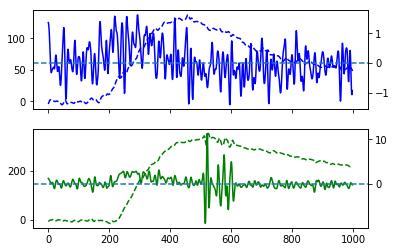

In [78]:
trialIndex = 111
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(-excTrialList[trialIndex].interestWindow[:fullWindowSize]*1e9, 'b--')
ax_copy = ax[0].twinx()
ax_copy.plot(np.diff(-excTrialList[trialIndex].interestWindow[:fullWindowSize]*1e9), c='b', label="Diff")
ax_copy.axhline(y=0.,linestyle='--')
ax[1].plot(inhTrialList[trialIndex].interestWindow[:fullWindowSize]*1e9, 'g--')
ax_copy = ax[1].twinx()
ax_copy.plot(np.diff(inhTrialList[trialIndex].interestWindow[:fullWindowSize]*1e9), c='g', label="Diff")
ax_copy.axhline(y=0.,linestyle='--')

plt.show()

In [124]:
trialIndex

149

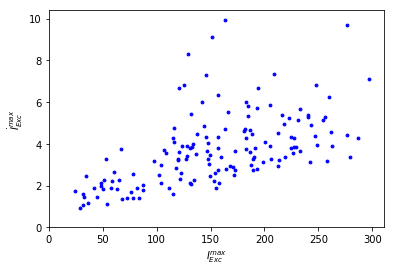

In [178]:
fig, ax = plt.subplots()
e_max, i_max, excMaxDiff, inhMaxDiff = [],[],[],[]
for trialIndex,trial in enumerate(excTrialList):
    e_max.append(np.max(-trial.interestWindow[:fullWindowSize]*1e9))
    excMaxDiff.append(np.max(-np.diff(trial.interestWindow[:fullWindowSize]*1e9)))
    i_max.append(np.max(inhTrialList[trialIndex].interestWindow[:fullWindowSize]*1e9))
    inhMaxDiff.append(np.max(np.diff(inhTrialList[trialIndex].interestWindow[:fullWindowSize]*1e9)))
ax.scatter(e_max, excMaxDiff,c='b',s=8)
# ax[1].scatter(i_max, inhMaxDiff, c='g',s=8)
ax.set_xlim(xmin=0.)
ax.set_ylim(ymin=0.)
ax.set_xlabel("$I_{Exc}^{max}$")
ax.set_ylabel("$\dot{I}_{Exc}^{max}$")
# ax[1].set_xlim(xmin=0.)
# ax[1].set_ylim(ymin=0.)
plt.show()

First figure is phase plots of E vs I, sorted from lowest to highest $Exc_{max}$ and arranged as left to right rasters. If the two variables are correlated in time, we expect to see a diagonal line with negative slope. The same is overplotted below on Figure 2. Will have to tidy this up a bit.

Figure 3 is bin-normalized correlations, looking at just shape changes in every bin.
Periodically normalized correlations

Figure 4 is trace-normalized correlations, looking at bin-wise correlations normalized to the whole trace.

In [184]:
import scipy.stats as ss

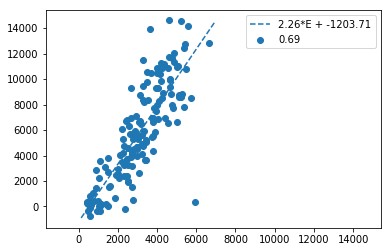

In [221]:
fullWindowSize = 1000
area_exc, area_inh = [], []
for exc, inh in zip(excTrialList,inhTrialList):
    area_exc.append(np.trapz(-exc.interestWindow[:fullWindowSize]*1e9)/20.) #nA.ms
    area_inh.append(np.trapz(inh.interestWindow[:fullWindowSize]*1e9)/20.) #nA.ms

slope, intercept, rval, pval, stderr =  ss.linregress(area_exc, area_inh)
fig, ax = plt.subplots()
ax.scatter(area_exc, area_inh, label="{:.2f}".format(rval**2))
xmin, xmax = ax.get_xlim()
ax.plot(np.linspace(xmin, xmax,100),slope*np.linspace(xmin, xmax,100) + intercept, '--', label="{:.2f}*E + {:.2f}".format(slope, intercept))
ax.set_xlim(ax.get_ylim())
plt.legend()
plt.show()

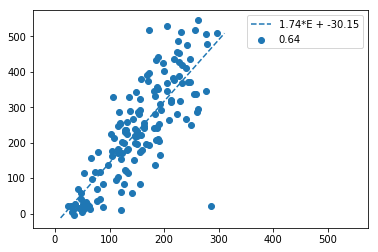

In [218]:
max_exc, max_inh = [], []
for exc, inh in zip(excTrialList,inhTrialList):
    max_exc.append(np.max(-exc.interestWindow[:fullWindowSize]*1e9))
    max_inh.append(np.max(inh.interestWindow[:fullWindowSize]*1e9))

    
slope, intercept, rval, pval, stderr =  ss.linregress(max_exc, max_inh)
fig, ax = plt.subplots()
ax.scatter(max_exc, max_inh, label="{:.2f}".format(rval**2))
xmin, xmax = ax.get_xlim()
ax.plot(np.linspace(xmin, xmax,100),slope*np.linspace(xmin, xmax,100) + intercept, '--', label="{:.2f}*E + {:.2f}".format(slope, intercept))
ax.set_xlim(ax.get_ylim())
plt.legend()
plt.show()